## Episode Sentiment Analysis

In [20]:
import json

# Specify the path to your JSON file
json_file_path_episode_dict = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/data/episodes_seasons_with_text.json'

# Open the file and load its contents as a dictionary
with open(json_file_path_episode_dict, 'r') as file:
    episode_dict = json.load(file)

In [21]:
episode_dict

{'Naruto: Original': [{'Episode Number': '1',
   'Episode Title': 'Enter:_Naruto_Uzumaki!',
   'Japanese Airdate': '3 October 2002',
   'episode synopsis text': "Twelve years ago, a vicious tailed beast known as the Nine-Tails attacked the shinobi village of Konohagakure. Many shinobi fought the beast but killed all those standing before it. The Fourth Hokage saved the town by sealing the beast with an infant boy at the cost of his own life.\n\nIn the present, Naruto Uzumaki is a prankster who is constantly causing trouble throughout Konohagakure, most recently having placed graffiti all over the Hokage Rock. Much of the village dislikes him, but he enjoys the attention garnered from reprimands, as he had no parents or friends due to the villagers abusing him daily. Despite claiming to be a talented shinobi who would someday become Hokage, Naruto cannot perform basic techniques such as the Clone Technique. When this leaves him unable to graduate from the Academy, one of his instructors

In [22]:
# Defining a function to read the labMT_wordlist file and creating a dictionary for each word and their sentiment scores:
def load_labmt_wordlist(file_path):
    word_scores = {}  
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:  
            parts = line.strip().split('\t')
            if len(parts) >= 3 and parts[0] != "word":  
                word = parts[0]
                score = float(parts[2]) if parts[2] != '--' else 5.0
                word_scores[word] = score
    return word_scores

labmt_wordlist_file = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/LabMT_wordlist.txt' # Name has been anonymized
labmt = load_labmt_wordlist(labmt_wordlist_file)

In [28]:
from nltk.tokenize import word_tokenize
import json

# Assuming 'final_dict_with_combined_descriptions' is your dictionary with episode descriptions
# Assuming 'labmt' is your LabMT wordlist dictionary

# Create a dictionary to store sentiment scores for each episode
sentiment_scores_episodes = {}

# Define a function to calculate the sentiment score
def calculate_sentiment(description, word_scores):
    if description is None:
        return None
    
    tokens = word_tokenize(description.lower())  # Tokenize and lowercase
    sentiment_scores_episodes = [word_scores.get(token, 0) for token in tokens]
    
    if sentiment_scores_episodes:
        average_sentiment = sum(sentiment_scores_episodes) / len(sentiment_scores_episodes)
        return average_sentiment
    else:
        return None  # Return None if no valid tokens found

# Iterate through episodes in the dictionary
all_sentiment_scores = []
for arc_name, episodes in episode_dict.items():
    for episode in episodes:
        episode_title = episode['Episode Title']
        episode_description = episode.get('episode synopsis text', '')  # Assuming this is the key for the description

        # Calculate sentiment score based on LabMT wordlist
        sentiment_score = calculate_sentiment(episode_description, labmt)
        
        # Append sentiment score to the episode dictionary
        episode['sentiment_score'] = sentiment_score

        # Store the sentiment score in the main dictionary
        sentiment_scores_episodes.setdefault(arc_name, []).append({'Episode Title': episode_title, 'Sentiment Score': sentiment_score})

        # Collect sentiment scores for episodes that are not None
        if sentiment_score is not None:
            all_sentiment_scores.append(sentiment_score)

# Calculate the average sentiment score for all episodes
average_sentiment_all_episodes = sum(all_sentiment_scores) / len(all_sentiment_scores)

# Assign the average sentiment score to episodes with None sentiment scores
for arc_name, episodes in sentiment_scores_episodes.items():
    for episode in episodes:
        if episode['Sentiment Score'] is None:
            episode['Sentiment Score'] = average_sentiment_all_episodes

# Print or use the sentiment scores as needed
for arc_name, episodes in sentiment_scores_episodes.items():
    print(f"Arc: {arc_name}")
    for episode in episodes:
        print(f"Episode: {episode['Episode Title']}, Sentiment Score: {episode['Sentiment Score']}")

# If you want to save the sentiment scores to a file (e.g., sentiment_scores.json)
with open('../data/sentiment_scores_episodes.json', 'w') as file:
    json.dump(sentiment_scores_episodes, file)


Arc: Naruto: Original
Episode: Enter:_Naruto_Uzumaki!, Sentiment Score: 3.7407368421052687
Episode: My_Name_is_Konohamaru!, Sentiment Score: 3.6494961240310126
Episode: Sasuke_and_Sakura:_Friends_or_Foes?, Sentiment Score: 3.9311638591117877
Episode: Pass_or_Fail:_Survival_Test, Sentiment Score: 3.8157432432432428
Episode: You_Failed!_Kakashi's_Final_Decision, Sentiment Score: 3.863647058823526
Episode: A_Dangerous_Mission!_Journey_to_the_Land_of_Waves!, Sentiment Score: 3.7532543443917863
Episode: The_Assassin_of_the_Mist!, Sentiment Score: 3.5386159169550178
Episode: The_Oath_of_Pain, Sentiment Score: 3.355276381909547
Episode: Kakashi:_Sharingan_Warrior!, Sentiment Score: 3.6500000000000004
Episode: The_Forest_of_Chakra, Sentiment Score: 3.664071856287428
Episode: The_Land_Where_a_Hero_Once_Lived, Sentiment Score: 4.179662162162165
Episode: Battle_on_the_Bridge!_Zabuza_Returns!, Sentiment Score: 3.7863025210084054
Episode: Haku's_Secret_Jutsu:_Demonic_Mirroring_Ice_Crystals, Sentime

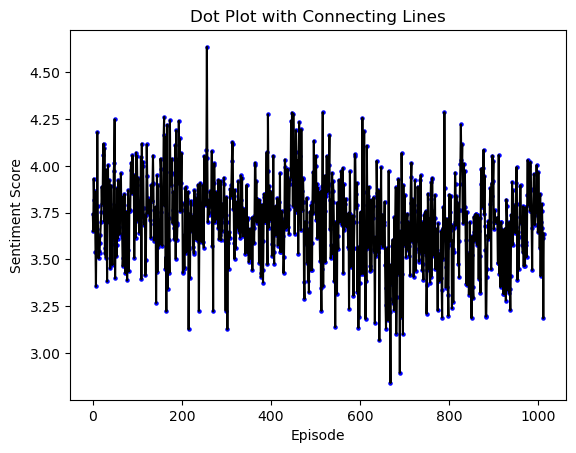

In [29]:
import matplotlib.pyplot as plt

# Assuming 'sentiment_scores' is the dictionary with sentiment scores

# Create a list to store y-values (sentiment scores)
y_values = []

# Iterate through arcs and episodes in the sentiment scores dictionary
for arc_name, episodes in sentiment_scores_episodes.items():
    for episode in episodes:
        y_values.append(episode['Sentiment Score'])

# Create a dot plot with tiny dots (size=1) or no dots (size=0)
plt.scatter(range(len(y_values)), y_values, label='Episodes', color='blue', s=5)  # Set the size to 1 for tiny dots, or 0 for no dots

# Connect the dots with lines
plt.plot(range(len(y_values)), y_values, linestyle='-', marker='', color='black')  # Set marker to '' for no dots

# Set plot labels and title
plt.title('Dot Plot with Connecting Lines')
plt.xlabel('Episode')
plt.ylabel('Sentiment Score')

# Show the plot
plt.show()


## Characther Sentiment Analysis

In [13]:
# Specify the path to your JSON file
json_file_path_characther_text = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/data/characters_texts.json'

# Open the file and load its contents as a dictionary
with open(json_file_path_characther_text, 'r') as file:
    characters_text = json.load(file)

In [14]:
from nltk.tokenize import word_tokenize

# Assuming 'final_dict_with_combined_descriptions' is your dictionary with combined Episode Descriptions
# Assuming 'labmt' is your LabMT wordlist dictionary

# Create a dictionary to store sentiment scores for each arc
sentiment_scores_charachters = {}

# Define a function to calculate the sentiment score
def calculate_sentiment(description, word_scores):
    # Ensure that description is a string
    description_str = ' '.join(description) if isinstance(description, list) else str(description)
    
    # Tokenize and lowercase
    tokens = word_tokenize(description_str.lower())
    
    # Calculate sentiment score based on LabMT wordlist
    sentiment_scores_charachters = [word_scores.get(token, 0) for token in tokens]
    
    if sentiment_scores_charachters:
        average_sentiment = sum(sentiment_scores_charachters) / len(sentiment_scores_charachters)
        return average_sentiment
    else:
        return None  # Return None if no valid tokens found

# Iterate through arcs in the dictionary
for character_name, combined_description in characters_text.items():
    # Calculate sentiment score based on LabMT wordlist
    sentiment_scores_charachters[character_name] = calculate_sentiment(combined_description, labmt)

# Print or use the sentiment scores as needed
for character_name, score in sentiment_scores_charachters.items():
    print(f"Character: {character_name}, Sentiment Score: {score}")

# If you want to save the sentiment scores to a file (e.g., sentiment_scores.json)
with open('../data/sentiment_scores_charachters.json', 'w') as file:
    json.dump(sentiment_scores_charachters, file)


Character: Akane, Sentiment Score: 3.6959190031152667
Character: Akemaru, Sentiment Score: 3.6194999999999995
Character: Ada, Sentiment Score: 3.9541736227045052
Character: Agira_Ryūdōin, Sentiment Score: 3.8489215686274525
Character: Agari_Kaisen, Sentiment Score: 3.6490361445783135
Character: Aoda, Sentiment Score: 3.392766749379652
Character: Akaboshi, Sentiment Score: 3.6516870415647884
Character: Amachi, Sentiment Score: 3.7765217391304367
Character: Akari, Sentiment Score: 3.8690643274853826
Character: Akebi_Sanzu, Sentiment Score: 3.8466081871345064
Character: Akari_Tatsushiro, Sentiment Score: 4.011535353535359
Character: Amado_Sanzu, Sentiment Score: 3.810792682926815
Character: Ajisai, Sentiment Score: 3.8323349339735744
Character: Ameyuki, Sentiment Score: 3.712694736842102
Character: Ameno, Sentiment Score: 3.9062939698492447
Character: Anko_Mitarashi, Sentiment Score: 3.7079616671736924
Character: Anbu_Commander, Sentiment Score: 3.6460428849902566
Character: Anaguma, Sent